In [377]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential 
from keras.layers import Dense,Activation,Dropout 
from keras.layers.normalization import BatchNormalization 
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold

In [378]:
def loadData(csv_file='ncsr_clean.csv', balance=True, random_seed=0):
    # Read csv
    df=pd.read_csv(csv_file).drop(['Unnamed: 0'], axis=1)
    df=df.loc[:293]
    
    if balance:
        df=df.append(df[df['Y']==0])
        
    # Get x and y values
    np.random.seed(random_seed)
    shuffled_idx=shuffle(range(len(df)))
    shuffled_df=df.iloc[shuffled_idx]
    y=shuffled_df['Y'].values
    X=shuffled_df.drop(['Y'], axis=1)
    X=(X-X.mean())/X.std()
    X=X/X.max()
    X=X.values
    
    return X,y
    
    
    

In [379]:
def split_70_30(X, y):
    # Split
    test_size=int(np.round(0.3*len(y)))
    X_train=X[test_size:]
    X_test=X[:test_size]
    y_train=y[test_size:]
    y_test=y[:test_size]

    y_train=to_categorical(y_train, num_classes=2)
    y_test=to_categorical(y_test, num_classes=2)
    
    return X_train, X_test, y_train, y_test

In [395]:
def splitTest(X,y, test_size=0.1):
    # Split
    test_size=int(np.round(test_size*len(y)))
    X_test=X[:test_size]
    X=X[test_size:]
    y_test=y[:test_size]
    y=y[test_size:]    
    return X, X_test, y, y_test

In [396]:
def createModel():
    # Make model
    model=Sequential()
    model.add(Dense(1000,input_dim=X_train.shape[1],activation='relu'))
    model.add(Dense(500,activation='relu'))
    model.add(Dense(200,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    optimizer=Adam(lr=1e-5)
    model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['binary_accuracy'])
    
    return model

In [494]:
def trainModel(model, X_train, y_train, X_test, y_test):
    # Train
    history=model.fit(X_train,y_train,validation_data=(X_test,y_test),\
              batch_size=30,\
              epochs=300,\
              verbose=0)
    return history

In [495]:
X, y=loadData(balance=True)
X, X_test, y, y_test=splitTest(X,y)
n_folds=5
skf=StratifiedKFold(n_splits=n_folds, shuffle=True)
history_list=[]
y_pred_list=[]
label_list=[]
i=0
for train, valid in skf.split(X, y):
    print("Fold", i+1, 'of', n_folds)
    model=None
    model=createModel()
    y_train=to_categorical(y[train], num_classes=2)
    y_valid=to_categorical(y[valid], num_classes=2)
    history=trainModel(model, X[train], y_train, X[valid], y_valid)
    history_list.append(history)
    
    y_pred=np.argmax(model.predict(X[valid]), axis=1)
    y_pred_list.append(y_pred)
    label_list.append(y_valid[:,1])
    
    print('Final training accuracy:', history.history['binary_accuracy'][-1])
    print('Final validation accuracy:', history.history['val_binary_accuracy'][-1])
    i+=1

Fold 1 of 5
Final training accuracy: 0.9963099600204243
Final validation accuracy: 0.8695652122082917
Fold 2 of 5
Final training accuracy: 0.9926199200408485
Final validation accuracy: 0.7971014354539954
Fold 3 of 5
Final training accuracy: 1.0
Final validation accuracy: 0.8970588147640228
Fold 4 of 5
Final training accuracy: 1.0
Final validation accuracy: 0.7313432729066308
Fold 5 of 5
Final training accuracy: 1.0
Final validation accuracy: 0.746268658495661


In [500]:
print((0.9963099600204243\
       +0.9926199200408485\
       +1\
       +1\
       +1
      )/5)
print((0.8695652122082917\
       +0.7971014354539954\
       +0.8970588147640228\
       +0.7313432729066308\
       +0.746268658495661
      )/5)

0.9977859760122545
0.8082674787657205


In [496]:
labels=y_valid[:, 0]
(labels==0).sum()
# (y_test==0).sum()

38

In [497]:
prediction=model.predict(X[test])
length=len(prediction)
y_label=np.argmax(y_valid, axis=1)
predict_label=np.argmax(prediction, axis=1)
print(predict_label)
accuracy=np.sum(y_label==predict_label)/length * 100 
print("Accuracy of the dataset",accuracy )

[1 1 1 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 0 1
 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 1 0 1 1 0 1 1 1 0 0 1 1 0 0 0]
Accuracy of the dataset 74.6268656716418


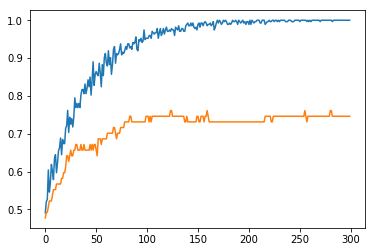

In [526]:
idx=4
plt.plot(history_list[idx].history['binary_accuracy'])
plt.plot(history_list[idx].history['val_binary_accuracy'])
plt.show()

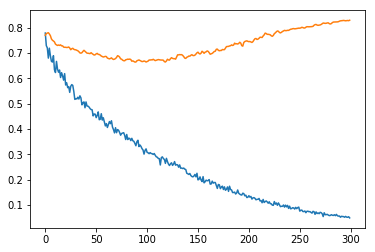

In [527]:
plt.plot(history_list[idx].history['loss'])
plt.plot(history_list[idx].history['val_loss'])
plt.show()

In [531]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(label_list[idx], y_pred_list[idx]))

from sklearn.metrics import f1_score
f1_score(label_list[idx], y_pred_list[idx])

[[20  9]
 [ 8 30]]


0.7792207792207793

In [529]:
model.save('NN_Dana.h5')